Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

Internal Libraries:

In [3]:
# Internal libraries:
from load_images import load_images

from preprocessing import normalize_dataset
from preprocessing import multiple_dataset_conversion

from plotting import plot_image_classes
from plotting import plot_cnn_history

from Models.base_cnn import build_cnn
from Models.base_cnn import train_cnn


Load images from the dataset

In [4]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

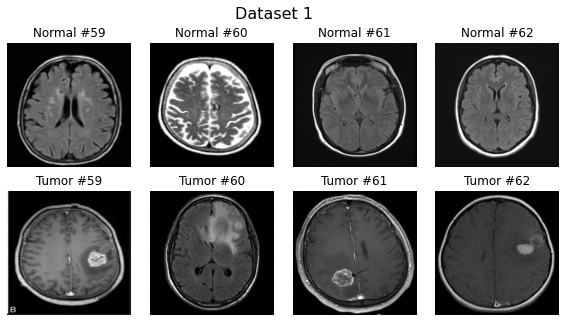

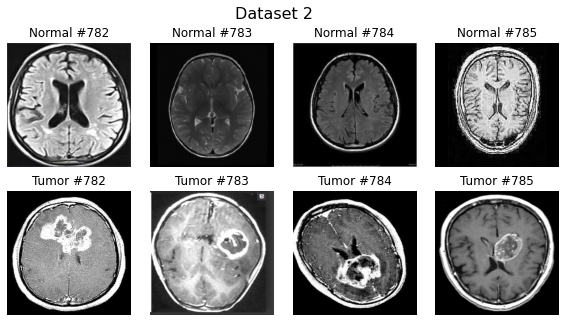

In [5]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Generic Preprocessing:

In [6]:
X, Y = multiple_dataset_conversion(yes=[dataset_1_tumor_images], no=[dataset_1_normal_images])
X, Y = normalize_dataset(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42, stratify=Y)

Basic CNN Model creation

In [7]:
base_cnn = build_cnn()
base_cnn_history, base_cnn_accuracy = train_cnn(base_cnn, X_train, Y_train, X_test, Y_test, epochs=10)

2022-04-02 17:25:21.515644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/Users/andrew/Desktop/School/CS4442/Final/CodingEnv/Advanced-AI-Thesis/Models/base_cnn.py:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size=batch_size),


3/3 [==============================] - 60s 27s/step - loss: 1.2766 - accuracy: 0.5833 - val_loss: 4.1653 - val_accuracy: 0.6140
Epoch 2/10
3/3 [==============================] - 10s 5s/step - loss: 2.4706 - accuracy: 0.5294
Epoch 3/10
3/3 [==============================] - 10s 5s/step - loss: 0.7747 - accuracy: 0.4706
Epoch 4/10
3/3 [==============================] - 10s 5s/step - loss: 0.9010 - accuracy: 0.2941
Epoch 5/10
3/3 [==============================] - 10s 5s/step - loss: 0.7386 - accuracy: 0.5294
Epoch 6/10
3/3 [==============================] - 10s 3s/step - loss: 0.7669 - accuracy: 0.5294
Epoch 7/10
3/3 [==============================] - 10s 3s/step - loss: 0.7076 - accuracy: 0.5882
Epoch 8/10
3/3 [==============================] - 10s 3s/step - loss: 0.8272 - accuracy: 0.5882
Epoch 9/10
3/3 [==============================] - 15s 5s/step - loss: 0.6730 - accuracy: 0.6250
Epoch 10/10
3/3 [==============================] - 10s 3s/step - loss: 0.7215 - accuracy: 0.5294
       

/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrew/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

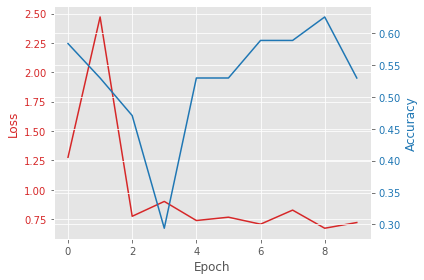

In [13]:
def plot_cnn_history(history: dict) -> None:
    
    """
        Plots the accuracy and loss of the model over the epochs.

        :param history: The history of the model.
    """

    N = len(history.history["loss"])
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(np.arange(0, N), history.history["loss"], color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = "tab:blue"
    ax2.set_ylabel("Accuracy", color=color)  # we already handled the x-label with ax1
    ax2.plot(np.arange(0, N), history.history["accuracy"], color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.title("Training Loss and Accuracy on Brain Dataset")
    plt.show()

plot_cnn_history(base_cnn_history)